In [1]:
from plotnine import *
import numpy as np
import datetime
import ray

In [2]:
import dask.dataframe as dd
from dask.distributed import Client
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:41607 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 15.54 GiB


In [3]:
which_device='C'

In [4]:
df = dd.read_parquet(f'../data/parameter_search/2021-03-19/{which_device}.parquet/')
df.head()

,time,y_diff,emf,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_config.coil_resistance,load_model.R,input_excitation
0,0.000,0.040000,0.0,3240,4.975303,-18.313053,71.012328,3.485714,0.006667,0.0,10.0,17.8,30,0
1,0.003,0.040022,0.0,3240,4.975303,-18.313053,71.012328,3.485714,0.006667,0.0,10.0,17.8,30,0
2,0.006,0.040088,0.0,3240,4.975303,-18.313053,71.012328,3.485714,0.006667,0.0,10.0,17.8,30,0
3,0.009,0.040195,0.0,3240,4.975303,-18.313053,71.012328,3.485714,0.006667,0.0,10.0,17.8,30,0
4,0.012,0.040343,0.0,3240,4.975303,-18.313053,71.012328,3.485714,0.006667,0.0,10.0,17.8,30,0


In [5]:
# Get the unique_model_ids once (we'll be using this to filter the larger file later)
unique_model_ids = df['model_id'].unique().compute().values
unique_model_ids

array([3240, 3241, 3242, ..., 6261, 6262, 6263])

In [6]:
from unified_model import evaluate
from unified_model.utils.utils import collect_samples

BASE_GROUNDTRUTH_PATH = '../data/2019-05-23_D/'
samples = {}
samples['A'] = collect_samples(base_path=BASE_GROUNDTRUTH_PATH,
                               acc_pattern='A/*acc*.csv',
                               adc_pattern='A/*adc*.csv',
                               video_label_pattern='A/*labels*.csv')
samples['B'] = collect_samples(base_path=BASE_GROUNDTRUTH_PATH,
                               acc_pattern='B/*acc*.csv',
                               adc_pattern='B/*adc*.csv',
                               video_label_pattern='B/*labels*.csv')
samples['C'] = collect_samples(base_path=BASE_GROUNDTRUTH_PATH,
                               acc_pattern='C/*acc*.csv',
                               adc_pattern='C/*adc*.csv',
                               video_label_pattern='C/*labels*.csv')

from unified_model.mechanical_components import MagnetAssembly
magnet_assembly = MagnetAssembly(m=1,
                                 l_m_mm=10,
                                 l_mcd_mm=0,
                                 dia_magnet_mm=10,
                                 dia_spacer_mm=10,
                                 mat_magnet='NdFeB',
                                 mat_spacer='iron')


samples_list = samples[which_device]

gtf = evaluate.GroundTruthFactory(
    samples_list=samples_list,
    lvp_kwargs=dict(magnet_assembly=magnet_assembly,
                seconds_per_frame=1 / 60,  # noqa
                pixel_scale=0.154508),
    adc_kwargs=dict(voltage_division_ratio=1 / 0.342))  # noqa

gt = gtf.make()
len(gt)

8

In [7]:
@ray.remote
def calc_metrics(df_slice, ground_truth, emf_metrics_dict, mech_metrics_dict):
    time_predict = df_slice['time'].values
    emf_predict = df_slice['emf'].values
    y_predict = df_slice['y_diff'].values

    elec_eval = evaluate.ElectricalSystemEvaluator(
        emf_target=ground_truth.elec.emf,
        time_target=ground_truth.elec.time,
        metrics=emf_metrics_dict
    )
    elec_eval.fit(
        emf_predict=emf_predict,
        time_predict=time_predict
    )
    
    mech_eval = evaluate.MechanicalSystemEvaluator(
        y_target=ground_truth.mech.y_diff,
        time_target=ground_truth.mech.time,
        metrics=mech_metrics_dict
    )
    
    mech_eval.fit(
        y_predict=y_predict,
        time_predict=time_predict,
    )
    
    elec_score = elec_eval.score()
    mech_score = mech_eval.score()
    elec_score.update(mech_score)
    return elec_score

In [8]:
ray.shutdown()

In [9]:
ray.init()

2021-05-10 09:47:35,533	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '146.232.221.115',
 'raylet_ip_address': '146.232.221.115',
 'redis_address': '146.232.221.115:6379',
 'object_store_address': '/tmp/ray/session_2021-05-10_09-47-34_650769_19395/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-10_09-47-34_650769_19395/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-05-10_09-47-34_650769_19395',
 'metrics_export_port': 49606,
 'node_id': '6c63d970f9dcfccf3ca7974c240800292edab0ea44e04a64dc5a9291'}

In [10]:
from tqdm.notebook import tqdm
from unified_model import metrics

/home/michael/miniconda3/envs/ds2/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/


In [12]:
emf_metrics_dict = {'emf_dtw_euclid_norm': metrics.dtw_euclid_norm_by_length,
                    'emf_dtw_dist': metrics.dtw_euclid_distance,
                    'rms_perc_diff_detrend': metrics.root_mean_square_percentage_diff} 

mech_metrics_dict = {
    'y_diff_dtw_euclid_norm': metrics.dtw_euclid_norm_by_length
}


input_numbers = range(len(samples_list))

print('Submitting to Ray...')
model_id_list = []
input_list = []
similarity_scores_list = []
for input_ in tqdm(input_numbers[4:]):
    print(f'Processing for input={input_}')
    
    df = dd.read_parquet(f'../data/parameter_search/2021-03-19/{which_device}.parquet/',
                         columns=['time', 'y_diff', 'emf', 'model_id', 'input_excitation'],
                         filters=[('input_excitation', '=', input_)]).compute()
    
    remaining_refs = []
    ready_refs = []
    for model_id in tqdm(unique_model_ids):
        df_slice = df.query(f'model_id == {model_id}').sort_values(by='time')
        ground_truth = gt[input_]
        remaining_refs.append(calc_metrics.remote(df_slice, ground_truth, emf_metrics_dict, mech_metrics_dict))
        
        # Must fit the shape of the original dataframe series
        model_id_list.append(model_id)
        input_list.append(input_)
    print('Polling for completed results...')
    while len(ready_refs) < len(unique_model_ids):  # Wait for all our model_ids to get processed
        ready_refs, remaining_refs = ray.wait(remaining_refs, num_returns=len(unique_model_ids), timeout=30)
        print(f'{datetime.datetime.now()} :: Remaining: {len(remaining_refs)}')
           
    print('Fetching results...')
    for ref in tqdm(ready_refs):
        similarity_scores_list.append(ray.get(ref))

Submitting to Ray...


  0%|          | 0/4 [00:00<?, ?it/s]

Processing for input=4


  0%|          | 0/7500 [00:00<?, ?it/s]

Polling for completed results...
2021-05-10 10:16:25.708620 :: Remaining: 0
Fetching results...


  0%|          | 0/7500 [00:00<?, ?it/s]

Processing for input=5


  0%|          | 0/7500 [00:00<?, ?it/s]

Polling for completed results...
2021-05-10 10:28:11.020498 :: Remaining: 0
Fetching results...


  0%|          | 0/7500 [00:00<?, ?it/s]

Processing for input=6


  0%|          | 0/7500 [00:00<?, ?it/s]

Polling for completed results...
2021-05-10 10:38:26.130129 :: Remaining: 0
Fetching results...


  0%|          | 0/7500 [00:00<?, ?it/s]

Processing for input=7


  0%|          | 0/7500 [00:00<?, ?it/s]

Polling for completed results...
2021-05-10 10:49:47.598163 :: Remaining: 0
Fetching results...


  0%|          | 0/7500 [00:00<?, ?it/s]

In [13]:
from collections import defaultdict

In [14]:
scores_dict = defaultdict(lambda: [])  # So we don't have to add a list first
for s in similarity_scores_list:
    for k,v in s.items():
        scores_dict[k].append(v)

In [15]:
scores_dict['model_id'] = model_id_list
scores_dict['input_excitation'] = input_list

In [16]:
import pandas as pd

df_test = pd.DataFrame(scores_dict)
df_test

,emf_dtw_euclid_norm,emf_dtw_dist,rms_perc_diff_detrend,y_diff_dtw_euclid_norm,model_id,input_excitation
0,0.017289,67.877488,-10.363779,0.002125,3240,4
1,0.017415,65.934920,-5.145268,0.002288,3241,4
2,0.017958,67.916947,0.558907,0.002465,3242,4
3,0.019074,72.063228,6.693371,0.002731,3243,4
4,0.020133,75.981064,13.051306,0.003073,3244,4
...,...,...,...,...,...,...
29995,0.019974,43.284091,-12.088185,0.002493,6259,7
29996,0.025902,54.756404,-29.162757,0.003050,6260,7
29997,0.024528,53.030372,-27.444609,0.002997,6261,7
29998,0.022241,47.839830,-20.549096,0.002567,6262,7


In [17]:
df_melt = df_test.drop(columns=['model_id', 'input_excitation']).melt(id_vars='emf_dtw_dist')
df_melt.head()

,emf_dtw_dist,variable,value
0,67.877488,emf_dtw_euclid_norm,0.017289
1,65.934920,emf_dtw_euclid_norm,0.017415
2,67.916947,emf_dtw_euclid_norm,0.017958
3,72.063228,emf_dtw_euclid_norm,0.019074
4,75.981064,emf_dtw_euclid_norm,0.020133


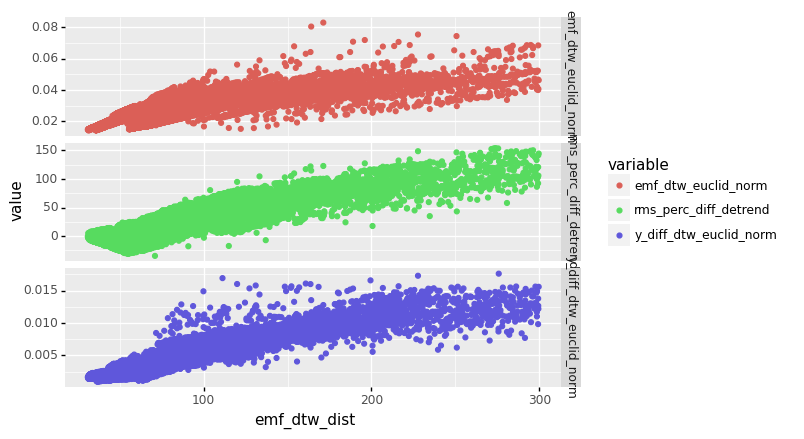

<ggplot: (-9223363310373691420)>

In [18]:
p = ggplot(aes(x='emf_dtw_dist', y='value', color='variable'), df_melt.query('emf_dtw_dist < 300'))
p + geom_point() + facet_grid('variable ~ .', scales='free')

In [19]:
df_test.to_parquet(f'../data/parameter_search/2021-03-19/{which_device}_similarity.parquet')

In [20]:
df_similarity = dd.read_parquet(f'../data/parameter_search/2021-03-19/{which_device}_similarity.parquet')
df_similarity

,emf_dtw_euclid_norm,emf_dtw_dist,rms_perc_diff_detrend,y_diff_dtw_euclid_norm,model_id,input_excitation
npartitions=1,,,,,,
,float64,float64,float64,float64,int64,int64
,...,...,...,...,...,...


In [21]:
df = dd.read_parquet(f'../data/parameter_search/2021-03-19/{which_device}.parquet/')
df['input_excitation'] = df['input_excitation'].astype(int)

In [22]:
df_merge = df.merge(df_similarity, how='inner', on=['model_id', 'input_excitation'])
df_merge.to_parquet(f'../data/parameter_search/2021-03-19/{which_device}_augmented_002.parquet', partition_on='input_excitation', compression='brotli')

In [44]:
df_merge = dd.read_parquet(f'../data/parameter_search/2021-03-19/{which_device}_augmented.parquet')
df_merge.head()

,time,y_diff,emf,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_config.coil_resistance,load_model.R,emf_dtw_euclid_norm,emf_dtw_dist,rms_perc_diff_detrend,y_diff_dtw_euclid_norm,input_excitation
0,0.000,0.040000,0.0,1872,10.490756,27.341203,148.431295,1.792857,0.011667,1.666667,5.0,23.5,30,0.043455,114.677197,19.942166,0.004143,0
1,0.003,0.040020,0.0,1872,10.490756,27.341203,148.431295,1.792857,0.011667,1.666667,5.0,23.5,30,0.043455,114.677197,19.942166,0.004143,0
2,0.006,0.040079,0.0,1872,10.490756,27.341203,148.431295,1.792857,0.011667,1.666667,5.0,23.5,30,0.043455,114.677197,19.942166,0.004143,0
3,0.009,0.040177,0.0,1872,10.490756,27.341203,148.431295,1.792857,0.011667,1.666667,5.0,23.5,30,0.043455,114.677197,19.942166,0.004143,0
4,0.012,0.040312,0.0,1872,10.490756,27.341203,148.431295,1.792857,0.011667,1.666667,5.0,23.5,30,0.043455,114.677197,19.942166,0.004143,0


In [23]:
df_merge.tail()

,time,y_diff,emf,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_config.coil_resistance,load_model.R,emf_dtw_euclid_norm,emf_dtw_dist,rms_perc_diff_detrend,y_diff_dtw_euclid_norm,input_excitation
64003,7.986,0.045945,0.0,3695,9.758717,55.496781,83.122703,4.05,0.005,4.166667,10.0,12.5,30,0.024644,72.699053,51.856865,0.001694,6
64004,7.989,0.045945,0.0,3695,9.758717,55.496781,83.122703,4.05,0.005,4.166667,10.0,12.5,30,0.024644,72.699053,51.856865,0.001694,6
64005,7.992,0.045946,0.0,3695,9.758717,55.496781,83.122703,4.05,0.005,4.166667,10.0,12.5,30,0.024644,72.699053,51.856865,0.001694,6
64006,7.995,0.045946,0.0,3695,9.758717,55.496781,83.122703,4.05,0.005,4.166667,10.0,12.5,30,0.024644,72.699053,51.856865,0.001694,6
64007,7.998,0.045947,0.0,3695,9.758717,55.496781,83.122703,4.05,0.005,4.166667,10.0,12.5,30,0.024644,72.699053,51.856865,0.001694,6


# So, we need to do something special here to join p1 and p2 from the C device.

In [23]:
df_1 = dd.read_parquet('../data/parameter_search/2021-03-19/C_augmented_001.parquet/')
df_1['input_excitation'] = df_1['input_excitation'].astype(int)
df_2 = dd.read_parquet('../data/parameter_search/2021-03-19/C_augmented_002.parquet/')
df_2['input_excitation'] = df_2['input_excitation'].astype(int)
df_1

,time,y_diff,emf,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_config.coil_resistance,load_model.R,emf_dtw_euclid_norm,emf_dtw_dist,rms_perc_diff_detrend,y_diff_dtw_euclid_norm,input_excitation
npartitions=939,,,,,,,,,,,,,,,,,,
,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [24]:
df_both = dd.concat([df_1, df_2])
df_both.to_parquet('../data/parameter_search/2021-03-19/C_augmented.parquet', partition_on='input_excitation', compression='brotli')